In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:

# Load the data
default_df = pd.read_csv("data/payment_default.csv")
history_df = pd.read_csv("data/payment_history.csv")

default_df = default_df.sort_values(by='client_id').reset_index(drop=True)
history_df = history_df.sort_values(by=['client_id', 'month']).reset_index(drop=True)

# Optional: display the first few rows after sorting
print(default_df.head())
print(history_df.head())

   client_id  credit_given  gender  education  marital_status  month  default
0          1         20000       2          2               1     10        1
1          2        120000       2          2               2     10        1
2          4         50000       2          2               1     10        0
3          7        500000       1          1               2     10        0
4          9        140000       2          3               1     10        0
   client_id  payment_status  bill_amt  paid_amt  month
0          1              -2         0         0      3
1          1              -2         0         0      4
2          1              -1         0         0      5
3          1              -1       689         0      6
4          1               2      3102       689      7


In [4]:
# Check for missing values
print("Missing Values in payment_default:\n", default_df.isnull().sum())
print("Missing Values in payment_history:\n", history_df.isnull().sum())


Missing Values in payment_default:
 client_id         0
credit_given      0
gender            0
education         0
marital_status    0
month             0
default           0
dtype: int64
Missing Values in payment_history:
 client_id         0
payment_status    0
bill_amt          0
paid_amt          0
month             0
dtype: int64


In [5]:

# =========================================================
# 2) Client-wise mean imputation for -2
# =========================================================

def impute_clientwise_mean(group):
    non_neg2 = group[group["payment_status"] != -2]["payment_status"]
    if not non_neg2.empty:
        mean_status = round(non_neg2.mean())
        group.loc[group["payment_status"] == -2, "payment_status_imputed_clientmean"] = mean_status
    else:
        group.loc[group["payment_status"] == -2, "payment_status_imputed_clientmean"] = 0
    return group

# Create column and fill default values to start
history_df["payment_status_imputed_clientmean"] = history_df["payment_status"]

# Apply group-wise imputation
history_df = history_df.groupby("client_id").apply(impute_clientwise_mean).reset_index(drop=True)

print(history_df["payment_status"].value_counts())
print(history_df["payment_status_imputed_clientmean"].value_counts()) 

payment_status
 0    70063
-1    25522
-2    18076
 2    13907
 1     2718
 3     1060
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64
payment_status_imputed_clientmean
 0    82612
-1    28047
 2    14134
 1     5492
 3     1061
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64


In [6]:
# Group by month and payment_status, then count occurrences
status_monthly_counts = history_df.groupby(["month", "payment_status_imputed_clientmean"]).size().unstack(fill_value=0)

# Display the result
print("=== Payment Status Counts by Month using payment_status_imputed_clientmean===")
print(status_monthly_counts)


=== Payment Status Counts by Month using payment_status_imputed_clientmean===
payment_status_imputed_clientmean    -1      0     1     2    3   4   5   6  \
month                                                                         
3                                  4773  14280   594  2128  125  40  10  16   
4                                  4617  14590   563  1979  132  57  15   4   
5                                  4673  14162   554  2356  139  47  20   5   
6                                  4814  13556   533  2815  175  58  13  14   
7                                  4693  13514   551  2884  249  73  16   7   
8                                  4477  12510  2697  1972  241  56  21   9   

payment_status_imputed_clientmean   7   8  
month                                      
3                                  32   2  
4                                  42   1  
5                                  42   2  
6                                  19   3  
7                        

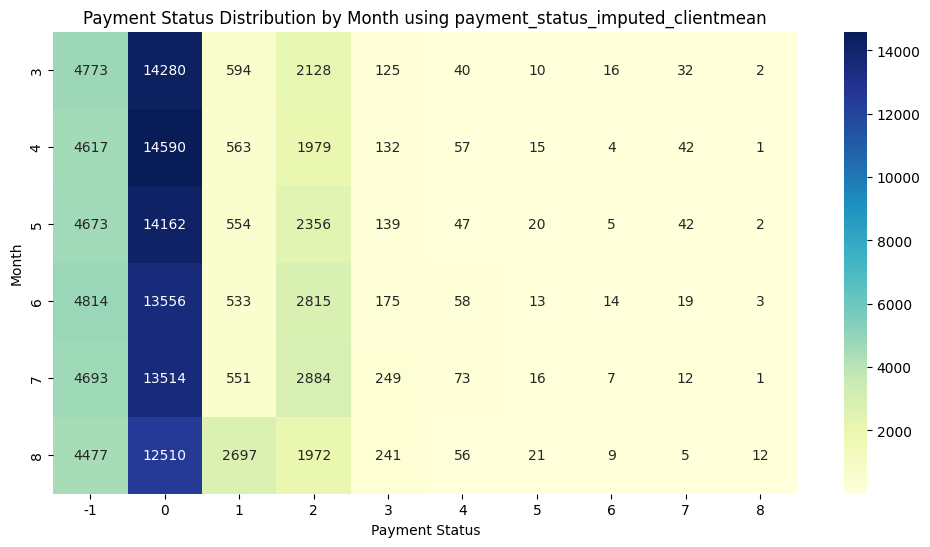

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(status_monthly_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Payment Status Distribution by Month using payment_status_imputed_clientmean")
plt.xlabel("Payment Status")
plt.ylabel("Month")
plt.show()

In [8]:
def month_wise_status_summary_with_counts(history_df):
    df = history_df.copy()
    df["status"] = df["payment_status_imputed_clientmean"]

    summary = df.groupby("month").apply(lambda g: pd.Series({
        "total_clients": g["client_id"].nunique(),
        "on_time_count": (g["status"] == 0).sum(),
        "late_count": (g["status"] > 0).sum(),
        "early_count": (g["status"] < 0).sum(),
        "on_time_pct": (g["status"] == 0).mean(),
        "late_pct": (g["status"] > 0).mean(),
        "early_pct": (g["status"] < 0).mean(),
        "avg_delay": g["status"].mean()
    })).reset_index()

    return summary


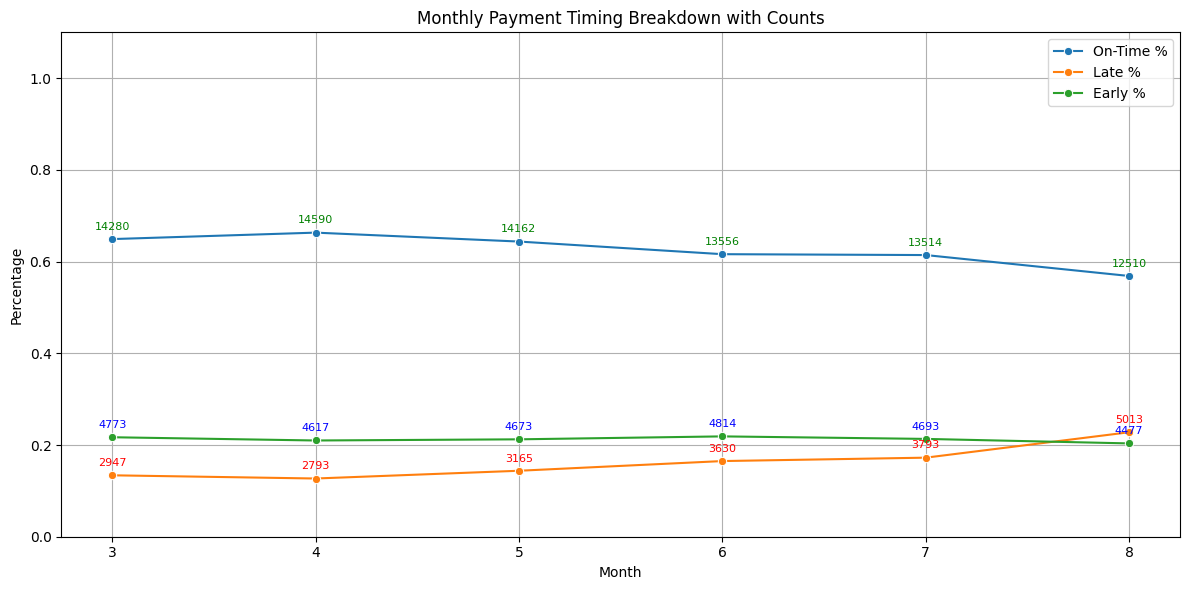

In [9]:
summary_df = month_wise_status_summary_with_counts(history_df)

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='on_time_pct', data=summary_df, label='On-Time %', marker='o')
sns.lineplot(x='month', y='late_pct', data=summary_df, label='Late %', marker='o')
sns.lineplot(x='month', y='early_pct', data=summary_df, label='Early %', marker='o')

# Annotate counts on each line
for i, row in summary_df.iterrows():
    plt.text(row['month'], row['on_time_pct'] + 0.02, f"{int(row['on_time_count'])}", ha='center', fontsize=8, color='green')
    plt.text(row['month'], row['late_pct'] + 0.02, f"{int(row['late_count'])}", ha='center', fontsize=8, color='red')
    plt.text(row['month'], row['early_pct'] + 0.02, f"{int(row['early_count'])}", ha='center', fontsize=8, color='blue')

plt.title("Monthly Payment Timing Breakdown with Counts")
plt.ylabel("Percentage")
plt.xlabel("Month")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:

def plot_client_history(history_df, client_id):
    """
    For a given client_id, shows:
      • Left subplot: payment_status (delay code) over time with integer y-axis
      • Right subplot: bill_amt vs paid_amt as side-by-side bars
    """
    df = history_df[history_df.client_id == client_id].sort_values("month")
    if df.empty:
        print(f"No history for client {client_id}")
        return

    months = df['month'].astype(int).tolist()
    x = np.arange(len(months))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

    # ─── 1) Payment Status ─────────────────────────────────────────────
    ax = axes[0]
    ax.plot(months, df['payment_status_imputed_clientmean'], marker='o', linestyle='-')
    ax.set_title("Payment Status (Delay Code)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Delay Code")
    ax.set_xticks(months)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # <-- Force integer y-axis

    # ─── 2) Bill vs Paid Amounts ───────────────────────────────────────
    ax = axes[1]
    width = 0.35
    ax.bar(x - width/2, df['bill_amt'], width, label='Bill Amt')
    ax.bar(x + width/2, df['paid_amt'], width, label='Paid Amt')
    ax.set_title("Bill vs Paid Amount")
    ax.set_xlabel("Month")
    ax.set_ylabel("Amount")
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    ax.legend()

    plt.suptitle(f"Client {client_id} Payment History", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

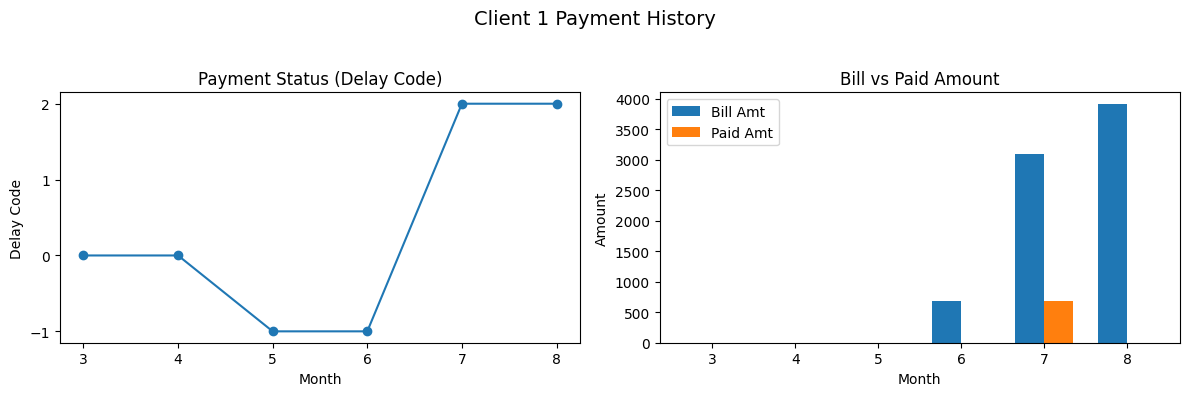

In [12]:
plot_client_history(history_df, client_id=1)


,client_id,payment_status,bill_amt,paid_amt,month,payment_status_imputed_clientmean
count,132000.000000,132000.000000,1.320000e+05,1.320000e+05,132000.000000,132000.000000
mean,14980.285636,-0.186371,4.487127e+04,5.264425e+03,5.500000,0.092856
std,8673.440143,1.166357,6.675669e+04,1.786846e+04,1.707832,0.941186
min,1.000000,-2.000000,-3.396030e+05,0.000000e+00,3.000000,-1.000000
25%,7437.250000,-1.000000,2.358000e+03,3.900000e+02,4.000000,0.000000
50%,15000.500000,0.000000,1.916100e+04,1.900000e+03,5.500000,0.000000
75%,22476.250000,0.000000,5.699900e+04,4.602250e+03,7.000000,0.000000
max,29997.000000,8.000000,1.664089e+06,1.684259e+06,8.000000,8.000000


In [ ]:
corr = history_df.drop